In [1]:
import os
import sys
import re
import math
from collections import defaultdict

import pandas as pd
import numpy as np
from tqdm import tqdm

import torch
from torch_geometric.data import Data, DataLoader
from sklearn.model_selection import train_test_split

import networkx as nx
import matplotlib.pyplot as plt

from rdkit import Chem
from rdkit.Chem import AllChem, Draw
from rdkit.Chem.rdmolfiles import MolFromXYZFile
from functions.data_loader import data_loader
from classes.smiles_to_graph import MolecularGraphFromSMILES
from classes.MPNN import MPNN
from functions.compute_loss import compute_loss
from functions.evaluations import *
from functions.evaluations import evaluate_model
from functions.train import train_MPNN_model

# Load the data and couple the SMILES to the yields and remove nan's

In [2]:
yields_path = "data/compounds_yield.csv"
smiles_path = "data/compounds_smiles.csv"

df_merged, yield_min, yield_max = data_loader(yields_path, smiles_path)

## Convert the SMILES strings to molecular Graphs

In [3]:
from rdkit import Chem

graphs = []
for _, row in tqdm(df_merged.iterrows(), total=len(df_merged), desc="Converting SMILES to graphs"):
    try:
        mol_graph = MolecularGraphFromSMILES(row['smiles_raw'])

        borylation_index = row['borylation_site']

        graph = mol_graph.to_pyg_data()
        graphs.append(graph)

    except Exception as e:
        print(f"Fout bij SMILES: {row['smiles_raw']}")
        print(f"  - borylation_site: {row['borylation_site']}")
        mol = Chem.MolFromSmiles(row['smiles_raw'])
        if mol:
            print(f"  - aantal atomen in RDKit mol: {mol.GetNumAtoms()}")
        else:
            print("  - RDKit kon mol niet parsen!")
        print(f"  - foutmelding: {e}")



Converting SMILES to graphs: 100%|██████████| 83/83 [00:01<00:00, 43.47it/s]


## Split the data into Train Test and Val, 70/15/15

In [4]:
train_val_graphs, test_graphs = train_test_split(
    graphs, test_size=0.15, random_state=42
)

train_graphs, val_graphs = train_test_split(
    train_val_graphs, test_size=0.1765, random_state=42
)

## Put the Graphs in a dataloader and initiate the MPNN model architecture

In [5]:
# Settings
batch_size = 16
num_epochs = 5
learning_rate = 0.001
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Architecture MPNN
node_in_feats=train_graphs[0].x.shape[1]                # Input features per node
edge_in_feats=train_graphs[0].edge_attr.shape[1]        # Input features per edge
hidden_feats=256                                         # Hidden features
num_step_message_passing=3                              # Steps voor message passing
readout_feats=512                                      # Readout features
activation='leaky_relu'                                 #  Activation function
dropout=0.2                                            # Dropout percentage

# DataLoaders
train_loader = DataLoader(train_graphs, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_graphs, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_graphs, batch_size=batch_size, shuffle=False)

# Initiate model
model = MPNN(
    node_in_feats=node_in_feats,
    edge_in_feats=edge_in_feats,
    hidden_feats=hidden_feats,
    num_step_message_passing=num_step_message_passing,
    readout_feats=readout_feats,
    activation=activation,
    dropout=dropout
)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training loop with validatie

train_total_loss_list = []
train_site_loss_list = []
train_yield_loss_list = []

val_r2_list = []
val_auc_list = []

/opt/anaconda3/envs/sobo/lib/python3.9/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


## Make the training loop

In [14]:
for epoch in range(num_epochs):
    train_losses = train_MPNN_model(model, train_loader, optimizer, device)
    val_metrics, val_y_true, val_y_pred = evaluate_model(model, val_loader, device, yield_min=yield_min, yield_max=yield_max)

    print(f"[Epoch {epoch+1}] Train loss: {train_losses['total']:.4f} | "
        f"Site: {train_losses['site']:.4f}, "
        f"Yield: {train_losses['yield']:.4f}")
    train_total_loss_list.append(train_losses['total'])
    train_site_loss_list.append(train_losses['site'])
    train_yield_loss_list.append(train_losses['yield'])

    val_r2_list.append(float(val_metrics['yield_R2']))
    val_auc_list.append(val_metrics['site_AUC'])

# Evaluate on testset after training
test_metrics, y_true, y_pred = evaluate_model(model, test_loader, device, yield_min=yield_min, yield_max=yield_max)



[Epoch 1] Train loss: 0.2333 | Site: 0.3455, Yield: 0.1211
[Epoch 2] Train loss: 0.1798 | Site: 0.2545, Yield: 0.1051
[Epoch 3] Train loss: 0.2300 | Site: 0.3615, Yield: 0.0985
[Epoch 4] Train loss: 0.1757 | Site: 0.2715, Yield: 0.0799
[Epoch 5] Train loss: 0.2470 | Site: 0.3593, Yield: 0.1347


## The loss plot against the amount of epochs

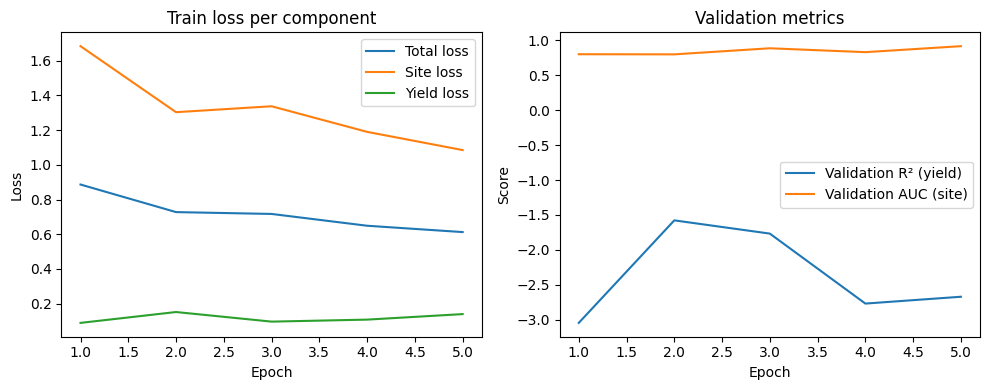

In [ ]:
epochs = list(range(1, num_epochs + 1))

plt.figure(figsize=(10, 4))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(epochs, train_total_loss_list, label="Total loss")
plt.plot(epochs, train_site_loss_list, label="Site loss")
plt.plot(epochs, train_yield_loss_list, label="Yield loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train loss per component")
plt.legend()

# Validation metrics
plt.subplot(1, 2, 2)
plt.plot(epochs, val_r2_list, label="Validation R² (yield)")
plt.plot(epochs, val_auc_list, label="Validation AUC (site)")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.title("Validation metrics")
plt.legend()

plt.tight_layout()
plt.show()

## Further evaluation measurements

In [ ]:
# Calculate Top-k accuracies (k=1 en k=3)
all_site_logits = []
all_site_masks = []
all_batches = []

with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        p_borylation, _ = model(batch.x, batch.edge_index, batch.edge_attr, batch.batch)

        all_site_logits.append(torch.sigmoid(p_borylation))  # sigmoid omdat topk op probs werkt
        all_site_masks.append(batch.borylation_mask)
        all_batches.append(batch.batch)

p_borylation = torch.cat(all_site_logits)
borylation_mask = torch.cat(all_site_masks)
batch_tensor = torch.cat(all_batches)

acc_top1 = topk_accuracy_softmax(p_borylation, borylation_mask, batch_tensor, k=1)
acc_top3 = topk_accuracy_softmax(p_borylation, borylation_mask, batch_tensor, k=3)

print(" Test results:")
print(f"\n Borylation site prediction:")
print(f"   - Accuracy      : {test_metrics['site_Accuracy']:.3f}")
print(f"   - Precision     : {test_metrics['site_Precision']:.3f}")
print(f"   - ROC AUC       : {test_metrics['site_AUC']:.3f}")
print(f"   - Top-1 Accuracy: {acc_top1:.3f}")
print(f"   - Top-3 Accuracy: {acc_top3:.3f}")

print(f"\n Yield prediction:")
print(f"   - MSE           : {test_metrics['yield_MSE']:.3f}")
print(f"   - MAE           : {test_metrics['yield_MAE']:.3f}")
print(f"   - R²            : {test_metrics['yield_R2']:.3f}")

print("Mean predicted yield:", y_pred.mean())
print("Mean ground truth yield:", y_true.mean())

 Testresultaten:

 Borylation site prediction:
   - Accuracy      : 0.607
   - Precision     : 0.213
   - ROC AUC       : 0.987
   - Top-1 Accuracy: 0.077
   - Top-3 Accuracy: 0.538

 Yield prediction:
   - MSE           : 607.411
   - MAE           : 22.424
   - R²            : -0.852
Gemiddelde voorspelde yield: 50.804287
Gemiddelde echte yield: 67.55167


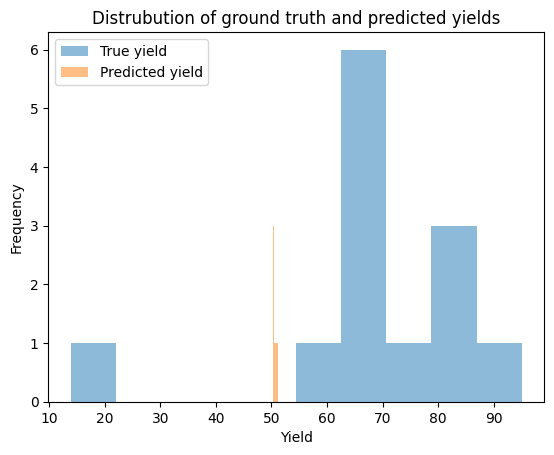

In [9]:
plt.hist(y_true, alpha=0.5, label="True yield")
plt.hist(y_pred, alpha=0.5, label="Predicted yield")
plt.legend()
plt.title("Distrubution of ground truth and predicted yields")
plt.xlabel("Yield")
plt.ylabel("Frequency")
plt.show()
